In [11]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import HBox, Label

In [2]:
def data_processing(dataFrame, features):
    x_vals = dataFrame[features]
    cat_feature = pd.get_dummies(x_vals["Employed"])
    scaler = StandardScaler().fit(x_vals)
    x_vals = scaler.transform(x_vals)
    x_vals = pd.DataFrame(x_vals, columns=features)
    x_vals["unemployed"], x_vals["employed"] = cat_feature[0], cat_feature[1]
    x_vals.insert(loc=0, column="placeholder", value=np.ones(len(x_vals)))
    y_vals = dataFrame.iloc[:, -1]
    x_vals_train, x_vals_test, y_vals_train, y_vals_test = train_test_split(x_vals, y_vals, random_state=25)
    x_vals_train, x_vals_test, y_vals_train, y_vals_test = x_vals_train.to_numpy(), x_vals_test.to_numpy(), \
                                                           y_vals_train.to_numpy(), y_vals_test.to_numpy()
    return x_vals_train, x_vals_test, y_vals_train, y_vals_test


def get_theta(coef, x):
    theta = 0.0
    for i in range(0, len(x)):
        theta = theta + (coef[i] * x[i])
    return theta


# This function returns the prediction based on the output of
# theta
def get_prediction(theta):
    prediction = 1 / (1 + np.exp(-theta))
    return prediction

# Takes array of coefficients previously used, the dependent
# variable values, the predicted value, the alpha, which
# will default to 0.3, and the array of x values
# This function will calculate the new coefficients and return
# them in the form of an array

def update_coef(coef_array, x_array, y, prediction, alpha):
    new_coef = []
    for i in range(0, len(x_array)):
        coef = coef_array[i] + alpha * (y - prediction) * prediction * (1 - prediction) * x_array[i]
        new_coef.append(coef)
    return new_coef

# Takes array
# Takes an array of x values, an array of coefficients,a "y"
# value and an alpha value, builds the theta value runs theta
# through the sigmoid function and runs that through the
# gradient descent algorithm, update_coef and returns an
# array of coefficients which will be used by the model with
# the non-training data.

def initialize_model(train_row, y, learning_rate):
    # initialize coefficient array with all 0.0
    initial_coef = []
    for i in range(0, len(train_row)):
        initial_coef.append(0.0)
    x_vals = train_row
    y = y
    theta = get_theta(initial_coef, x_vals)
    prediction = get_prediction(theta)
    return update_coef(initial_coef, x_vals, y, prediction, learning_rate)

# Takes independent variables as array, coefficients as array,
# dependent variabls as array, and a learning rate as a float
# Generates theta value using coefficients
def build_model_epoch(independent_variables, coef, dependent_variables, learning_rate):

    coefficients = coef
    predictions = []
    for i in range(0, len(independent_variables)):
        theta = get_theta(coefficients, independent_variables[i])
        prediction = get_prediction(theta)
        coefficients = update_coef(coefficients, independent_variables[i], \
                                        dependent_variables[i], prediction, learning_rate)
        if prediction < 0.5:
            predictions.append(0)
        else:
            predictions.append(1)
            
    one_is_one, zero_is_zero, one_is_zero, zero_is_one = get_raw_test_results(predictions, dependent_variables)
    score = get_score(one_is_one, zero_is_zero, one_is_zero, zero_is_one)
    

    return coefficients, score

def build_model(learning_rate, epoch_count, independent_variables, dependent_variables):
    coefficients = initialize_model(independent_variables[0], dependent_variables[0], learning_rate)
    scores = []
    for i in range(0, epoch_count):
        coefficients, score = build_model_epoch(independent_variables, coefficients, dependent_variables,
                                              learning_rate)
        scores.append(score)

    return coefficients, scores


def test_model(model_coef, test_inde_vars):
    coef = model_coef
    predictions = []
    for i in range(0, len(test_inde_vars)):
        theta = get_theta(coef, test_inde_vars[i])
        prediction = get_prediction(theta)
        if prediction < 0.5:
            predictions.append(0)
        else:
            predictions.append(1)
    return predictions

def get_raw_test_results(test, y_vals_test):
    one_is_one = 0
    zero_is_zero = 0
    one_is_zero = 0
    zero_is_one = 0

    for i in range(0, len(test)):
        if test[i] == 1 and y_vals_test[i] == 1:
            one_is_one += 1
        elif test[i] == 0 and y_vals_test[i] == 0:
            zero_is_zero += 1
        elif test[i] == 0 and y_vals_test[i] == 1:
            one_is_zero += 1
        else:
            zero_is_one += 1
    return one_is_one, zero_is_zero, one_is_zero, zero_is_one

def get_score(one_is_one, zero_is_zero, one_is_zero, zero_is_one):
    total = one_is_one + zero_is_zero + one_is_zero + zero_is_one
    total_correct = one_is_one + zero_is_zero
    score = total_correct / total * 100
    return score

def standardize_value(series, original_value):
    series_internal = series
    x = pd.Series([original_value])
    series_internal.append(x, ignore_index=True)
    x_bar = series_internal.mean()
    stdv = series_internal.std()
    standardized_value = (x - x_bar) / stdv
    return standardized_value

In [3]:
# Pull csv training dataset into Pandas dataframe
# Split dataframe into dependent and independent variables
# Normalize x values using min/max scaler
# Add placeholder value of 1 to x values array to account for
# the intercept coefficient
# Split dep and indep dataframes into training and test
training_data_set = pd.read_csv("Default_Fin.csv")
features = ["Employed","Bank Balance", "Annual Salary"]

In [7]:
annual_income_text = widgets.BoundedIntText(
    value = 0,
    min = 0,
    max = 1000000000,
    step = 1,
    description = 'Enter the customer\'s annual income',
    disabled = False
)
display(annual_income_text)
annual_income_text.keys

BoundedIntText(value=0, description="Enter the customer's annual income", max=1000000000)

['_dom_classes',
 '_model_module',
 '_model_module_version',
 '_model_name',
 '_view_count',
 '_view_module',
 '_view_module_version',
 '_view_name',
 'continuous_update',
 'description',
 'description_tooltip',
 'disabled',
 'layout',
 'max',
 'min',
 'step',
 'style',
 'value']

In [14]:
bank_balance_text = HBox([Label('Enter the customer\'s bank balance: '),\
                          widgets.BoundedIntText(
                                                    value = 0,
                                                    min = 0,
                                                    max = 1000000000,
                                                    step = 1,
                                                    disabled = False
                                                )
                         ])
display(bank_balance_text)

In [50]:
salary = standardize_value(training_data_set["Annual Salary"], annual_income_text.value)
current_balance = standardize_value(training_data_set["Bank Balance"],  bank_balance_text.value)

In [6]:
x_train, x_test, y_train, y_test = data_processing(training_data_set, features)
model, epoch_scores = build_model( 0.01, 10, x_train, y_train)
print(epoch_scores)
test = test_model(model, x_test)
score1, score2, score3, score4 = get_raw_test_results(test, y_test)
score = get_score(score1, score2, score3, score4)
print(score)

[96.64, 96.65333333333334, 96.70666666666666, 96.70666666666666, 96.77333333333334, 96.82666666666667, 96.93333333333334, 96.96000000000001, 97.02666666666667, 97.04]
97.08


Text(0.5, 0, 'Epoch Count')

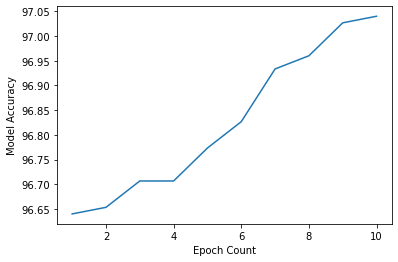

In [7]:
plt.plot(np.linspace(1,10, 10),epoch_scores)
plt.ylabel('Model Accuracy')
plt.xlabel('Epoch Count')